# EXPLORATION 8 : 인물사진을 만들어 보자

## 준비한 데이터
- 인물사진을 만들 사진들
- 합성할 배경들
- DeepLab 모델

## 1. DeepLab 모델 준비

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### 모델 정의 및 사전 훈련된 가중치 다운로드 및 로드

In [3]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [4]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

## 2. 배경 블러 처리하기

In [5]:
img_dir_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'
save_dir_path = os.getenv('HOME')+'/aiffel/human_segmentation/new_images'

In [6]:
def blur_background(file, label):
    # 이미지 불러오기
    img_path = os.path.join(img_dir_path, file)
    img_orig = cv2.imread(img_path)
    
    # 이미지를 pre-trained 모델에 입력
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())

    # 배경과 피사체 분리하기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0) # 예측 중 특정 라벨만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 결과를 원래 크기로 복원하기
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

    # 배경 흐리게 하기
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    plt.imshow(img_bg)
    plt.show()

    img_bg_blur = cv2.blur(img_bg, (13,13))
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    # 흐린 배경과 원본 이미지 합성 후 저장
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    save_path = os.path.join(save_dir_path, file)
    cv2.imwrite(save_path, img_concat)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

(884, 1334, 3) (339, 513, 3) 15


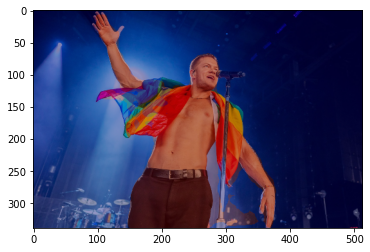

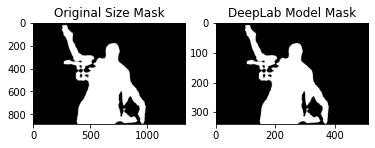

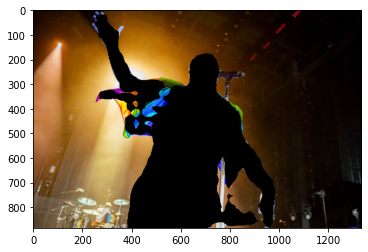

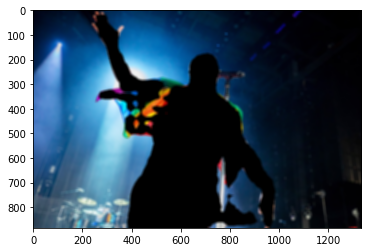

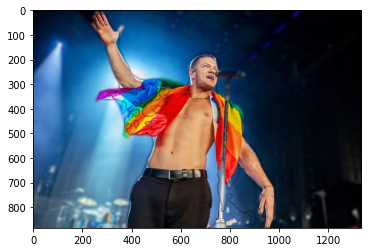

In [7]:
blur_background('ID.png', 'person')

### 문제점

오.. 인물사진으로 만드니 무대 위에 있는 댄 레이놀즈를 좀 더 부각시켜준다.   
그런데 문제점은 무지개색 천이 누끼안으로 들어간 부분이 있고 포함이 안된부분이 있어서 얼룩처럼 생겨버렸다.

(395, 597, 3) (339, 513, 3) 15


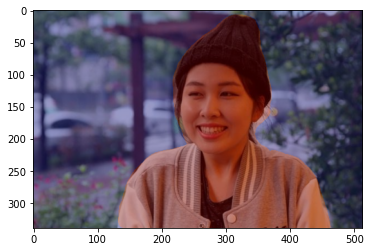

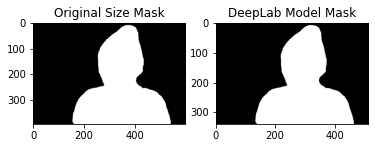

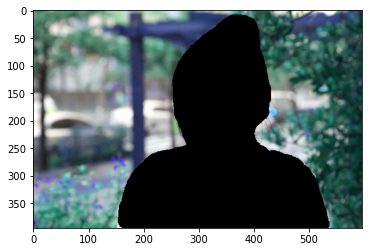

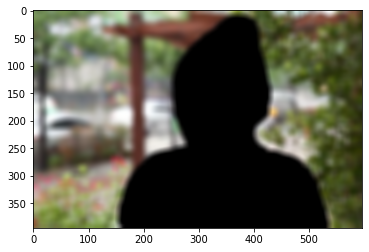

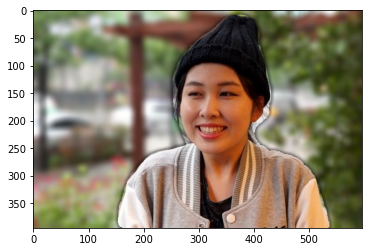

In [8]:
blur_background('kwon.png', 'person')

(931, 698, 3) (513, 384, 3) 8


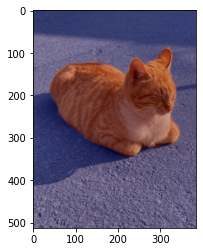

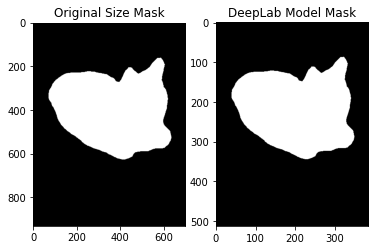

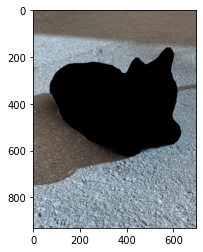

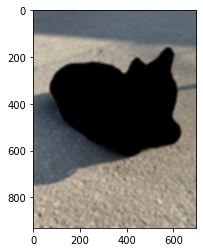

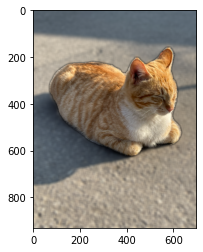

In [9]:
blur_background('cat.png', 'cat')

### 문제점
사람도, 고양이도 잘 분리를 하는데 문제점은 경계선처리가 너무 어색하다.   
피사체를 분리하고 배경에 다시 합성하면서 누끼를 잘못딴 부분이 남아서 그런것 같다.

## 3. 배경 합성하기

In [10]:
def chroma_key(file, label, background):
    # 이미지 불러오기
    img_path = os.path.join(img_dir_path, file)
    img_orig = cv2.imread(img_path)
    
    # 이미지를 pre-trained 모델에 입력
    img_resized, seg_map = MODEL.run(img_orig)

    # 배경과 피사체 분리하기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0) # 예측 중 특정 라벨만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 결과를 원래 크기로 복원하기
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    # 배경 이미지 불러오기
    bg_path = os.path.join(img_dir_path, background)
    bg_orig = cv2.imread(bg_path)
    target_size = (img_orig.shape[1], img_orig.shape[0])
    bg_resized = cv2.resize(bg_orig, target_size)
    
    # 배경과 원본 이미지 합성 후 저장
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_concat = np.where(img_mask_color==255, img_orig, bg_resized)
    save_path = os.path.join(save_dir_path, file)
    cv2.imwrite(save_path, img_concat)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

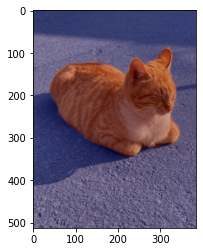

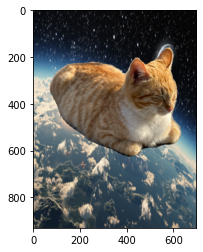

In [11]:
chroma_key('cat.png', 'cat', 'back4.png')

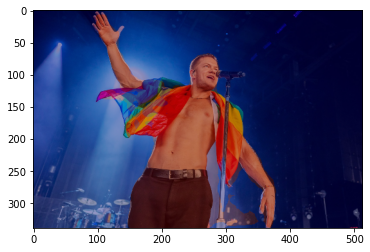

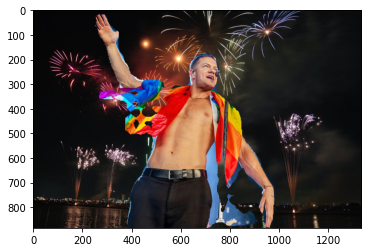

In [12]:
chroma_key('ID.png', 'person', 'back2.png')

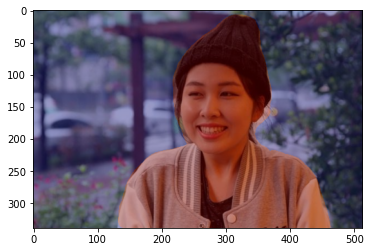

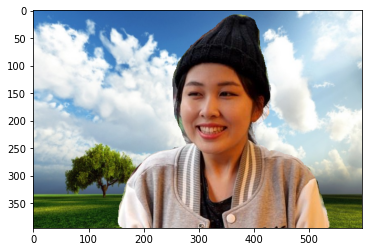

In [13]:
chroma_key('kwon.png', 'person', 'back1.png')

### 문제점
원래 본인 사진과 다시 합쳤을때는 티가 많이 안나서 몰랐는데  
다른 배경과 합성을 할 때에는 누끼를 잘못딴 부분이 포함되어있어 깔끔하지가 않고 티가 많이 난다.  
경계선 처리에서 모델의 성능을 더 높여야 할 것 같다.

### 해결책
- 경계 블러 처리 : 포토샵을 배울때 합성한 사진이 어색하지 않게 보이기 위해 경계쪽을 블러처리를 해주고는 하는데 같은 원리로 경계를 블러처리를 해주면 누끼가 잘못 따진 부분이 좀 더 자연스럽게 배경에 녹아들 것 같다. 

- 사진을 찍을 때 애초에 레이저를 사용하여 물체로부터의 거리를 포착하고 센서로 반사광을 측정하는 LiDAR 센서가 있다면 피사체를 구분해내어 인물사진을 바로 만들 수 있을텐데 지금은 이미 찍은 사진을 처리해주는 것이기 때문에 거리정보가 있지 않아서 다음 해결책을 제시할 수 있을 것 같다. 

    1. 중요하지 않은 픽셀의 초점을 제거하는 자동 마스킹 기술
    2. 깊이 맵을 사용한 측광 재구성 오류 수정
    3. 다중 스케일 깊이 추정  

참고링크 : [Recognizing Depth in Autonomous Driving](https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6)